<a href="https://colab.research.google.com/github/sgpuzzle19/sgpuzzle19/blob/main/Optimized_Scheduling_Carrier_GeneticAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading Data**

In [3]:
import pandas as pd
import re
import matplotlib.dates as mdates  # Import mdates for date formatting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from the Excel file
def load_excel_data(file_path):
    # Read Locations sheet
    locations_df = pd.read_excel(file_path, sheet_name="Locations",
                                 usecols=["Location Name", "X-Coordinate [mm]", "Y-Coordinate [mm]", "Capacity limitation (# SC)"])

    # Read Vehicles sheet
    vehicles_df = pd.read_excel(file_path, sheet_name="Vehicles",
                                usecols=["ID", "StartLocation", "LogOn", "LogOff"])

    # Read ContainerOrders sheet
    orders_df = pd.read_excel(file_path, sheet_name="ContainerOrders",
                              usecols=["TractorOrderId", "ContainerOrderId", "OriginLocation", "DestinationLocation", "Time first known", "Length"])

    return locations_df, vehicles_df, orders_df

# Parse Log File
def parse_log_file(log_file):
    vehicle_logs = []

    with open(log_file, "r") as file:
        for line in file:
            match = re.search(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) INFO (SC\d+) starting (TO_CO_\w+)#(CO_\w+)#(\w+)', line)
            if match:
                timestamp, vehicle_id, tractor_order, container_order, action = match.groups()
                vehicle_logs.append({
                    "Timestamp": timestamp,
                    "Vehicle": vehicle_id,
                    "TractorOrderId": tractor_order,
                    "ContainerOrderId": container_order,
                    "Action": action
                })

    return pd.DataFrame(vehicle_logs)

##### check the parse file for null or values error####
##### merge log file with ContainerOrders sheet for more info ######

# Match Log Data with Container Orders
def match_logs_to_orders(orders_df, logs_df):
    # Merge logs with orders using ContainerOrderId
    merged_df = orders_df.merge(logs_df, on="ContainerOrderId", how="left")
    return merged_df

# Main function
if __name__ == "__main__":
    excel_file = "/content/drive/MyDrive/Straddle_carrier_Scheduling/VOSimu-InputInformation.xlsx"  # Change to your actual file path
    locations, vehicles, orders = load_excel_data(excel_file)

    log_file = "/content/drive/MyDrive/Straddle_carrier_Scheduling/logger_all.log"  # Replace with actual log file path
    logs_df = parse_log_file(log_file)

    print("Sample Locations Data:")
    locations.to_csv("//content/drive/MyDrive/Straddle_carrier_Scheduling/locations.csv", index=False)
    print(locations.head())

    print("\nSample Vehicles Data:")
    vehicles.to_csv("/content/drive/MyDrive/Straddle_carrier_Scheduling/vehicles.csv", index=False)
    print(vehicles.head())

    print("\nSample Orders Data:")
    orders.to_csv("//content/drive/MyDrive/Straddle_carrier_Scheduling/orders.csv", index=False)
    print(orders.head())

    matched_df = match_logs_to_orders(orders, logs_df)
    # Save to CSV
    matched_df.to_csv("/content/drive/MyDrive/Straddle_carrier_Scheduling/before_optimization.csv", index=False)

    print("Matched Orders and Vehicle Activities:")
    print(matched_df.head())  # Display the first few rows

    # locations_dict = locations.set_index('Location Name').to_dict(orient='index')
    # #print("Locations Data Processed:\n", locations.head())

    # locations_capacity = {}
    # # Iterate over the dataframe and populate the locations_capacity dictionary
    # for _, row in locations.iterrows():
    #     location = row['Location Name']
    #     capacity = row['Capacity limitation (# SC)'] if pd.notna(row['Capacity limitation (# SC)']) else '>2'  # Use the provided capacity or '>2' if missing

    #     # Add location and its capacity to the dictionary
    #     locations_capacity[location] = capacity

    # # Print the locations_capacity dictionary to verify
    # #print(locations_capacity)
    # # Convert locations_capacity to DataFrame before saving
    # #locations_capacity_df = pd.DataFrame(list(locations_capacity.items()), columns=['Location', 'Capacity'])
    # #locations_capacity_df.to_csv("/content/drive/MyDrive/Location_capacity.csv", index=False)





Sample Locations Data:
  Location Name  X-Coordinate [mm]  Y-Coordinate [mm]  \
0      WS001.01             479241             919607   
1      WS002.01             479241             869607   
2      WS003.01             479241             819607   
3      WS004.01             479241             769607   
4      WS007.01             479241             719607   

   Capacity limitation (# SC)  
0                         2.0  
1                         2.0  
2                         2.0  
3                         2.0  
4                         2.0  

Sample Vehicles Data:
      ID StartLocation               LogOn              LogOff
0  SC001    YARD001.09 2024-08-21 06:40:00 2024-08-21 16:30:00
1  SC002    YARD001.10 2024-08-21 06:40:00 2024-08-21 16:30:00
2  SC003    YARD001.11 2024-08-21 06:40:00 2024-08-21 16:30:00
3  SC004    YARD001.12 2024-08-21 06:40:00 2024-08-21 16:30:00
4  SC005    YARD001.13 2024-08-21 06:40:00 2024-08-21 16:30:00

Sample Orders Data:
     TractorOrderId 

**Data Exploration and preprocessing**

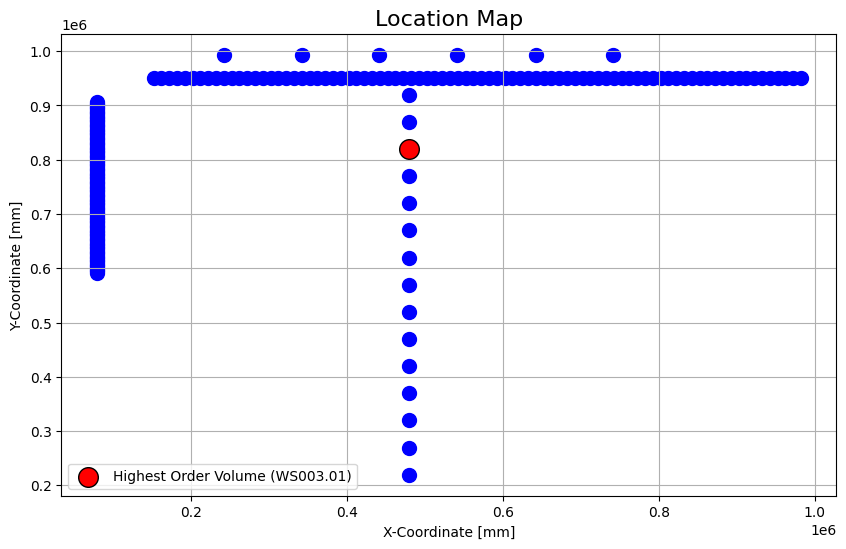

<ipython-input-4-aba440571eb0>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=order_count.index, y=order_count.values, palette='Blues_d')


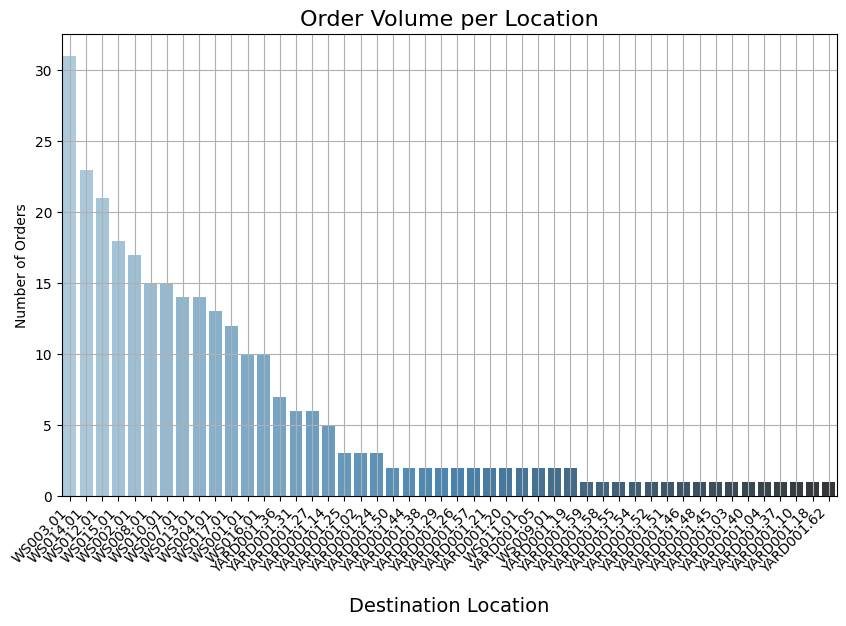

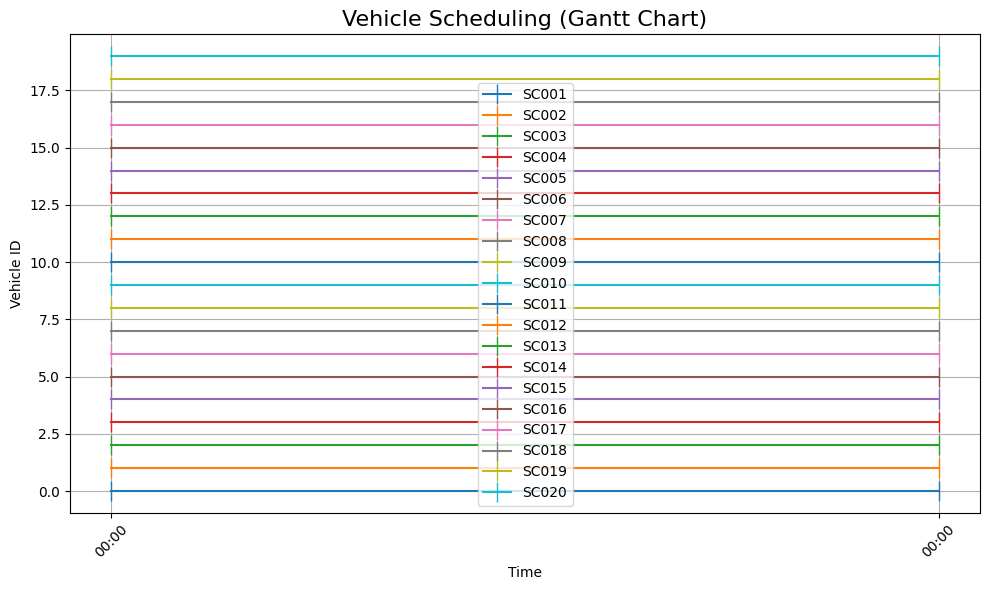

In [4]:
# Load all csv files
locations_df = pd.read_csv("/content/drive/MyDrive/Straddle_carrier_Scheduling/locations.csv")
vehicles_df = pd.read_csv("/content/drive/MyDrive/Straddle_carrier_Scheduling/vehicles.csv")
orders_df = pd.read_csv("/content/drive/MyDrive/Straddle_carrier_Scheduling/orders.csv")

# First, let's get all possible locations from all sources
all_locations = set()
# From locations_df
all_locations.update(locations_df["Location Name"].values.astype(str))
# From orders_df - both origin and destination
all_locations.update(orders_df["OriginLocation"].values.astype(str))
all_locations.update(orders_df["DestinationLocation"].values.astype(str))
# From vehicles_df - start locations
all_locations.update(vehicles_df["StartLocation"].values.astype(str))

# Clean up locations - strip whitespace and remove any empty strings for better Name handling and avoid errors
all_locations = {loc.strip() for loc in all_locations if isinstance(loc, str) and loc.strip()}

# Convert locations to a dictionary for quick lookup
locations = {
    row["Location Name"]: (row["X-Coordinate [mm]"], row["Y-Coordinate [mm]"], row.get("Capacity limitation (# SC)", None))
    for _, row in locations_df.iterrows()
}

# Convert vehicles to a dictionary for quick lookup
vehicles = {
    row["ID"]: {"start_location": row["StartLocation"], "logon": row["LogOn"], "logoff": row["LogOff"]}
    for _, row in vehicles_df.iterrows()
}

# Convert orders to a dictionary
orders = {
    row["TractorOrderId"]: {
        "container_order": row["ContainerOrderId"],
        "origin": row["OriginLocation"],
        "destination": row["DestinationLocation"],
        "time_known": row["Time first known"],
        "length": row["Length"]
    }
    for _, row in orders_df.iterrows()
}


# 1. Mapping Locations: Visualize locations on a 2D map using X and Y coordinates
plt.figure(figsize=(10, 6))
plt.scatter(locations_df['X-Coordinate [mm]'], locations_df['Y-Coordinate [mm]'], c='blue', s=100)
# Highlight the location with the highest order volume (WS003.01)
highlight = locations_df[locations_df['Location Name'] == 'WS003.01']
plt.scatter(highlight['X-Coordinate [mm]'], highlight['Y-Coordinate [mm]'], c='red', s=200, edgecolors='black', label='Highest Order Volume (WS003.01)')
# for i, txt in enumerate(locations_df['Location Name']):
#     plt.annotate(txt,(locations_df['X-Coordinate [mm]'][i], locations_df['Y-Coordinate [mm]'][i]), fontsize=8)
plt.title('Location Map', fontsize=16)
plt.xlabel('X-Coordinate [mm]')
plt.ylabel('Y-Coordinate [mm]')
plt.grid(True)
plt.legend()
plt.savefig('/content/drive/MyDrive/Straddle_carrier_Scheduling/location_map.png', format='png', dpi=300)
plt.show()

# # 2. Capacity Utilization: Analyze the capacity limitation
# plt.figure(figsize=(10, 6))
# sns.barplot(x=locations_df['Location Name'], y=locations_df['Capacity limitation (# SC)'], palette='viridis')
# plt.title('Location Capacity Utilization', fontsize=16)
# plt.xlabel('Location Name')
# plt.ylabel('Capacity Limitation (# SC)')
# plt.grid(False)
# plt.show()

# 3. Order Volume: Analyze the number of orders per location
order_count = orders_df['DestinationLocation'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=order_count.index, y=order_count.values, palette='Blues_d')
plt.title('Order Volume per Location', fontsize=16)
plt.xlabel('Destination Location', fontsize=14, labelpad=15)  # Adjust font size and padding
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels by 45 degrees and align them to the right
plt.ylabel('Number of Orders')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/Straddle_carrier_Scheduling/order_volume.png', format='png', dpi=300)
plt.show()

# 4. Vehicle Scheduling: Plotting the Gantt chart
plt.figure(figsize=(10, 6))
for i, row in vehicles_df.iterrows():
    plt.plot([row['LogOn'], row['LogOff']], [i, i], marker='|', markersize=15, label=row['ID']) # Changed 'Vehicle ID' to 'ID'
plt.title('Vehicle Scheduling (Gantt Chart)', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Vehicle ID')
plt.xticks(rotation=45)
# Convert 'LogOn' and 'LogOff' to datetime objects for proper formatting
vehicles_df['LogOn'] = pd.to_datetime(vehicles_df['LogOn'])
vehicles_df['LogOff'] = pd.to_datetime(vehicles_df['LogOff'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.grid(True)
plt.legend()
plt.savefig('/content/drive/MyDrive/Straddle_carrier_Scheduling/gantt_chart.png', format='png', dpi=300)
plt.tight_layout()
plt.show()


**Genetic Algorithm code with its main components: Fitness, population, selection, crossover, mutation**

In [36]:
import numpy as np
import random
from itertools import permutations
from datetime import datetime, timedelta
import pickle
import pandas as pd

# Constants
VEHICLE_SPEED = 5.57 # m/s units
REFERENCE_DATE = datetime(2024, 8, 21, 0, 0, 0)

# Find the earliest log-on time from vehicles
earliest_logon = pd.to_datetime(vehicles_df["LogOn"]).min()
# Find the earliest "Time first known" from orders
earliest_order_time = pd.to_datetime(orders_df["Time first known"]).min()
# Set the simulation start time to the minimum of both
simulation_time = min(earliest_logon, earliest_order_time)
print(f"Simulation Start Time: {simulation_time}")

# time conversion to datetime format
def convert_to_time(seconds):
    if pd.isna(seconds):  # If NaN, return an empty string or NaN
        return "Missing Data"

    return (REFERENCE_DATE + timedelta(seconds=float(seconds))).strftime('%Y-%m-%d %H:%M:%S')

# Manhattan Distance Calculation
def manhattan_dist(loc1, loc2):
    loc1 = loc1.strip()
    loc2 = loc2.strip()
    x1, y1, _ = locations[loc1]
    x2, y2, _ = locations[loc2]
    return abs(x2 - x1) + abs(y2 - y1)

# Fitness function with constraints: log on/off times, pick/drop times, capacity limitations
def fitness(schedule):
    total_time = 0
    location_usage = {loc: [] for loc in locations_df}
    time_windows = []  # List to store time window data

    # Compute current simulated time based on REFERENCE_DATE
    #simulation_time = REFERENCE_DATE

    for vehicle, jobs in schedule.items():
        # Retrieve vehicle data
        vehicle_data = vehicles_df[vehicles_df["ID"] == vehicle]

        if vehicle_data.empty:
              continue  # Skip if vehicle is not found
              print(f"Warning: Vehicle {vehicle} not found in vehicles_df! Skipping.")

        logon_time = pd.to_datetime(vehicle_data["LogOn"].values[0])
        logoff_time = pd.to_datetime(vehicle_data["LogOff"].values[0])
        #print(f"Vehicle {vehicle} LogOn: {logon_time}, LogOff: {logoff_time}")

        # Check if the vehicle is logged on during the simulation time
        if not (logon_time <= simulation_time <= logoff_time):
              print(f"Skipping Vehicle {vehicle} - Not logged on at {simulation_time}")
              continue  # Skip this vehicle if it is not logged on

        vehicle_time = 0
        current_location = vehicles[vehicle]['start_location']
        for job in jobs:
            order = orders[job]

            # Calculate arrival at origin
            distance_to_origin  = manhattan_dist(current_location, order["origin"]) / 1000
            # Calculate travel time in seconds using the speed
            travel_time = distance_to_origin / VEHICLE_SPEED  # Time = Distance / Speed

            simulation_time_seconds = (simulation_time - REFERENCE_DATE).total_seconds()
            #print(f"Simulation Start Time seconds: {simulation_time_seconds}")
            time_known = pd.to_numeric(order["time_known"], errors='coerce')
            arrival_time = max(simulation_time_seconds + travel_time, time_known)

            origin_location = order["origin"].strip()
            # Handle origin capacity and waiting
            default_tuple = (None, None, None)
            capacity = locations.get(origin_location, default_tuple)[2]
            waiting_time = 0
            if capacity is not None and origin_location in location_usage:
                if len(location_usage[origin_location]) >= capacity:
                    waiting_time = 60  # Waiting Penalty
                    arrival_time += waiting_time

            pickup_start = arrival_time
            pickup_end = arrival_time + 10  # Pickup takes 60 seconds

            # Store pickup time window with total time
            time_windows.append({
                'Vehicle': vehicle,
                'Task': f'Pickup_{job}',
                'Location': origin_location,
                'TotalTime_afterPick': pickup_end,
                'WaitingTime': waiting_time,
                'TravelTime': travel_time
            })

            if origin_location in location_usage:
                location_usage[origin_location].append(pickup_end)

            # Calculate arrival at destination
            distance_to_dest = manhattan_dist(order["origin"], order["destination"]) / 1000
            travel_time_to_dest = distance_to_dest / VEHICLE_SPEED  # Time = Distance / Speed
            destination_arrival = pickup_end + travel_time_to_dest

            destination_location = order["destination"].strip()
            dest_capacity = locations.get(destination_location, (None, None, None))[2]

            waiting_time = 0
            if dest_capacity is not None and destination_location in location_usage:
                if len(location_usage[destination_location]) >= dest_capacity:
                    waiting_time = 10  # Waiting Penalty
                    destination_arrival += waiting_time

            dropoff_start = destination_arrival
            dropoff_end = destination_arrival + 60  # Dropoff takes 60 seconds

            if destination_location in location_usage:
                location_usage[destination_location].append(dropoff_end)

            current_location = order["destination"]
            vehicle_time = dropoff_end

            # Store dropoff time window with total time
            time_windows.append({
                'Vehicle': vehicle,
                'Task': f'Dropoff_{job}',
                'Location': destination_location,
                'TotalTime/ Time first Known': dropoff_end,
                'WaitingTime': waiting_time,
                'TravelTime': travel_time_to_dest
            })
            DEBUG_MODE = False
            if DEBUG_MODE:
                print(f"Arrival time at {origin_location}: {convert_to_time(arrival_time)}")
                print(f"Pickup end time at {origin_location}: {convert_to_time(pickup_end)}")
                print(f"Dropoff end time at {destination_location}: {convert_to_time(dropoff_end)}")


        total_time = max(total_time, vehicle_time)

    # Create DataFrame from time windows
    time_windows_df = pd.DataFrame(time_windows) # Define time_windows_df before accessing it


    # Convert all time-related columns to datetime
    time_columns = {
        'TotalTime_afterPick': 'TotalTime_afterPick_datetime',
        'TotalTime/ Time first Known': 'TotalTime_firstKnown_datetime',
        'WaitingTime': 'WaitingTime_datetime',
        'TravelTime': 'TravelTime_datetime'
    }

    for original_col, new_col in time_columns.items():
        if original_col in ['WaitingTime', 'TravelTime']:
            # For WaitingTime and TravelTime, add to REFERENCE_DATE directly
            time_windows_df[new_col] = time_windows_df[original_col].apply(
                lambda x: REFERENCE_DATE + timedelta(seconds=float(x)) if pd.notna(x) else pd.NaT
            )
        else:
            # For other columns, use convert_to_time
            time_windows_df[new_col] = time_windows_df[original_col].apply(convert_to_time)

    # Drop the original columns (TotalTime_afterPick, WaitingTime, TravelTime, TotalTime/ Time first Known)
    columns_to_drop = ['TotalTime_afterPick', 'WaitingTime', 'TravelTime', 'TotalTime/ Time first Known']
    time_windows_df = time_windows_df.drop(columns=columns_to_drop)

    # Save to CSV with all formatted columns
    time_windows_df.to_csv("/content/drive/MyDrive/Straddle_carrier_Scheduling/time_details.csv",
                          index=False,
                          date_format='%Y-%m-%d %H:%M:%S')

    #time_windows_df.to_csv("/content/drive/MyDrive/Straddle_carrier_Scheduling/time_details.csv", index=False)
    return total_time


# Generate Initial Population
def generate_population(size):
    population = []
    for _ in range(size):
        ## Corrected to use orders_df and vehicles_df for sampling
        schedule = {vehicle_id: random.sample(list(orders_df['TractorOrderId'].unique()), len(orders_df))
                    for vehicle_id in vehicles_df['ID'].unique()} # Use unique vehicle IDs
        population.append(schedule)
    return population

# Selection
def select(population):
    # Sort by total_time returned by fitness directly
    return sorted(population, key=fitness)[:len(population)//2]

# Crossover
def crossover(parent1, parent2):
    crossover_point = len(orders) // 2
    child = {k: parent1[k][:crossover_point] + parent2[k][crossover_point:] for k in parent1}
    return child

# Mutation
def mutate(schedule):
    vehicle = random.choice(list(schedule.keys()))
    if len(schedule[vehicle]) > 1:
        i, j = random.sample(range(len(schedule[vehicle])), 2)
        schedule[vehicle][i], schedule[vehicle][j] = schedule[vehicle][j], schedule[vehicle][i]
    return schedule

# Genetic Algorithm Execution
def genetic_algorithm(iterations=20, pop_size=10):
    population = generate_population(pop_size)

    for _ in range(iterations):
        population = select(population)

        next_gen = []
        while len(next_gen) < pop_size:
            p1, p2 = random.sample(population, 2)
            child = crossover(p1, p2)
            if random.random() < 0.1:
                child = mutate(child)
            next_gen.append(child)

        population = next_gen

    best_schedule = select(population)[0]
    return best_schedule

# Run Algorithm
best_solution = genetic_algorithm()
print(f"Optimized Schedule:", best_solution)

# time_windows_df creation
total_time = fitness(best_solution)
print (f"Total time is", convert_to_time(total_time))

# Save best solution as a pickle file
with open("/content/drive/MyDrive/Straddle_carrier_Scheduling/schedule.pkl", "wb") as f:
    pickle.dump(best_solution, f)

print("Best schedule saved to 'schedule.pkl' and time windows saved to 'time_details.csv'.")


Simulation Start Time: 2024-08-21 06:40:00
Optimized Schedule: {'SC001': ['TO_CO_TFTU000286', 'TO_CO_TFTU000152', 'TO_CO_TFTU000125', 'TO_CO_TFTU000241', 'TO_CO_TFTU000049', 'TO_CO_TFTU000073', 'TO_CO_TFTU000096', 'TO_CO_TFTU000009', 'TO_CO_TFTU000260', 'TO_CO_TFTU000105', 'TO_CO_TFTU000181', 'TO_CO_TFTU000166', 'TO_CO_TFTU000006', 'TO_CO_TFTU000232', 'TO_CO_TFTU000156', 'TO_CO_TFTU000177', 'TO_CO_TFTU000207', 'TO_CO_TFTU000187', 'TO_CO_TFTU000145', 'TO_CO_TFTU000149', 'TO_CO_TFTU000070', 'TO_CO_TFTU000198', 'TO_CO_TFTU000102', 'TO_CO_TFTU000281', 'TO_CO_TFTU000225', 'TO_CO_TFTU000042', 'TO_CO_TFTU000110', 'TO_CO_TFTU000214', 'TO_CO_TFTU000088', 'TO_CO_TFTU000033', 'TO_CO_TFTU000224', 'TO_CO_TFTU000012', 'TO_CO_TFTU000075', 'TO_CO_TFTU000155', 'TO_CO_TFTU000066', 'TO_CO_TFTU000275', 'TO_CO_TFTU000004', 'TO_CO_TFTU000097', 'TO_CO_TFTU000163', 'TO_CO_TFTU000059', 'TO_CO_TFTU000199', 'TO_CO_TFTU000189', 'TO_CO_TFTU000106', 'TO_CO_TFTU000170', 'TO_CO_TFTU000074', 'TO_CO_TFTU000169', 'TO_CO

**Fitness function with constraints: log on/off times, pick/drop times, capacity limitations**

Genetic algorithm method is to give multiple best solution for same order irrespective of there provided origin and destination. It tries to optimize the route to give best solution

In [37]:
df = pd.read_csv('/content/drive/MyDrive/Straddle_carrier_Scheduling/time_details.csv')
print(df.head(8))  # Show first 8 rows to see complete pickup-dropoff cycle

  Vehicle                      Task    Location TotalTime_afterPick_datetime  \
0   SC001   Pickup_TO_CO_TFTU000286  RAIL001.93          2024-08-21 06:41:31   
1   SC001  Dropoff_TO_CO_TFTU000286    WS003.01                 Missing Data   
2   SC001   Pickup_TO_CO_TFTU000152       QC006          2024-08-21 06:41:10   
3   SC001  Dropoff_TO_CO_TFTU000152  YARD001.24                 Missing Data   
4   SC001   Pickup_TO_CO_TFTU000125       QC005          2024-08-21 06:40:49   
5   SC001  Dropoff_TO_CO_TFTU000125    WS001.01                 Missing Data   
6   SC001   Pickup_TO_CO_TFTU000241       QC004          2024-08-21 06:40:29   
7   SC001  Dropoff_TO_CO_TFTU000241    WS009.01                 Missing Data   

  TotalTime_firstKnown_datetime WaitingTime_datetime  TravelTime_datetime  
0                  Missing Data  2024-08-21 00:00:00  2024-08-21 00:01:21  
1           2024-08-21 06:44:17  2024-08-21 00:00:00  2024-08-21 00:01:45  
2                  Missing Data  2024-08-21 00:00:0